In [1]:
import os
import psutil

def toRelPath(origPath):
    """Converts path to path relative to current script

    origPath:	path to convert
    """
    try:
        if not hasattr(toRelPath, "__location__"):
            toRelPath.__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__)))
        return os.path.join(toRelPath.__location__, origPath)
    except NameError:
        return origPath
    
def getMBUsage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1e6
    
#0: 1080Ti, 1: 940MX
#os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

####end of library

In [2]:
%load_ext Cython
%matplotlib inline

import json
import datetime
import numpy
import pandas
import matplotlib.pyplot as plt
import mpld3
import statsmodels.api as sm
import sklearn
import keras
import math

print("Memory:", getMBUsage())

Using TensorFlow backend.


Memory: 216.584192


In [21]:
PRICE_POINT_EPS = 1e-8
TIMESTEP_SIZE = 500
POST_COMMISSION = 1

mpld3.disable_notebook()
#mpld3.enable_notebook()

In [33]:
with open(toRelPath("data\\db-20180718-1400.json")) as infile:
    jsonEvents = json.load(infile)
    
#sort by time
jsonEvents.sort(key = lambda x: x[1])
    
#convert
events = pandas.DataFrame(data = jsonEvents, columns = ["id", "time", "side", "price", "remaining", "reason"])
events = events.astype({"id": numpy.int64, 
                        "time": numpy.int64, 
                        "side": numpy.uint8, 
                        "price": float, 
                        "remaining": float, 
                        "reason": numpy.uint8})
del jsonEvents
print(events.dtypes)
print(events)
print("Events:", len(events))
print("Memory:", getMBUsage())

id             int64
time           int64
side           uint8
price        float64
remaining    float64
reason         uint8
dtype: object
            id           time  side    price      remaining  reason
0         4033  1531796818288     1  6735.17       0.000816       2
1            0  1531796818314     0     0.00       0.000000       0
2            1  1531796818412     0     0.01  117557.000000       5
3            2  1531796818412     0     0.02   12959.500000       5
4            3  1531796818412     0     0.03      33.000000       5
5            4  1531796818412     0     0.04       0.000550       5
6            5  1531796818412     0     0.05    8693.000000       5
7            6  1531796818412     0     0.10   13377.000000       5
8            7  1531796818412     0     0.11    2311.000000       5
9            8  1531796818412     0     0.12     101.000000       5
10           9  1531796818412     0     0.13    1539.960000       5
11          10  1531796818412     0     0.14

In [34]:
#get max price
maxPrice = numpy.int32(events.loc[events["price"].idxmax()]["price"])
print("Max price:", maxPrice)

#check price point granularity issues
print("Price point diffs:", events[events["price"] * 100 - round(events["price"] * 100) > PRICE_POINT_EPS])

#get first connect first trade event
firstConnect = events.index.get_loc(events[events["reason"] == 0].iloc[0].name)
print("First connect event index:", firstConnect)
firstTrade = events.index.get_loc(events[events["reason"] == 3].iloc[0].name)
print("First trade event index:", firstTrade)

#half-second steps
startTime = numpy.int64(events.iloc[firstConnect]["time"])
endTime = numpy.int64(events.iloc[-1]["time"])
steps = math.ceil((endTime - startTime) / TIMESTEP_SIZE)
print("Time bounds:", startTime, endTime, steps)

#assume price points are in cent granularity
curOB = pandas.DataFrame(numpy.zeros((math.ceil(maxPrice) * 100 + 1, 2)), columns = ["bid", "ask"])

#stats to gather at each timestep
cols = ["time", 
        "low", 
        "high", 
        "mid", 
        "last-trade"]
stats = pandas.DataFrame(numpy.zeros((steps, len(cols))), columns = cols)
print("Memory:", getMBUsage())

Max price: 1000000
Price point diffs: Empty DataFrame
Columns: [id, time, side, price, remaining, reason]
Index: []
First connect event index: 1
First trade event index: 4330
Time bounds: 1531796818314 1531872753002 151870
Memory: 598.110208


In [35]:
%%cython
def update():
    pass

In [36]:
lastProcTime = startTime
maxBid = 0
minAsk = maxPrice * 100
lastTradePrc = None

#walk through events, simulating a fixed time-series
npEvents = events.values
npCurOB = curOB.values
npStats = stats.values
for a in range(firstConnect + 1, len(npEvents)): #first event guaranteed to be a connect event
    event = npEvents[a]
    
    if (a - firstConnect - 1) % 10000 == 0:
        print(100 * a / (len(npEvents) - (firstConnect + 1)), end = "\r")
    
    #walk through missed timesteps up to but not including this time
    for b in range(lastProcTime, numpy.int64(event[1]), TIMESTEP_SIZE):
        ind = int(round((b - startTime) / TIMESTEP_SIZE))
        npStats[ind][0] = b - startTime
        npStats[ind][1] = maxBid / 100
        npStats[ind][2] = minAsk / 100
        npStats[ind][3] = (maxBid + minAsk) / 200
        npStats[ind][4] = lastTradePrc
    lastProcTime = b
    
    #special events are identified by the reason
    if event[5] == 0: #connect
        #zero OB
        continue
    if event[5] == 1: #disconnect
        continue
    if event[5] == 3: #trade event
        lastTradePrc = event[3]
    
    pp = numpy.int32(round(event[3] * 100))

    #update orderbook min/max
    ind = 0
    if event[2] == 1: #ask
        ind = 1
        if event[4] > 0:
            minAsk = min(minAsk, pp)
        else:
            for minAsk in range(minAsk + 1, maxPrice + 1):
                if npCurOB[minAsk][1] > 0:
                    break
    else: #bid
        if event[4] > 0:
            maxBid = max(maxBid, pp)
        else:
            for maxBid in range(maxBid + 1, -1, -1):
                if npCurOB[maxBid][0] > 0:
                    break
                    
    #update ob
    npCurOB[pp][ind] = event[4]
    
del events
del curOB

print(stats)
print("Memory:", getMBUsage())

              time      low     high       mid  last-trade
0              0.0  6733.88  6733.99  6733.935         NaN
1            500.0  6733.88  6733.99  6733.935         NaN
2           1000.0  6733.88  6734.00  6733.940         NaN
3           1500.0  6733.88  6734.00  6733.940         NaN
4           2000.0  6733.88  6734.96  6734.420         NaN
5           2500.0  6733.88  6734.96  6734.420         NaN
6           3000.0  6733.88  6735.14  6734.510         NaN
7           3500.0  6733.98  6735.15  6734.565         NaN
8           4000.0  6733.98  6735.15  6734.565         NaN
9           4500.0  6733.98  6735.15  6734.565         NaN
10          5000.0  6733.98  6735.15  6734.565         NaN
11          5500.0  6733.98  6735.15  6734.565         NaN
12          6000.0  6733.98  6735.15  6734.565         NaN
13          6500.0  6733.98  6735.16  6734.570         NaN
14          7000.0  6733.98  6735.16  6734.570         NaN
15          7500.0  6733.98  6735.20  6734.590         N

In [37]:
#cutoff
#stats = stats[(-7200 * 24):] #7200 is one hour
print("Memory:", getMBUsage())

Memory: 626.368512


Memory: 632.451072


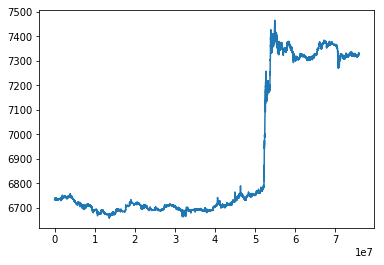

In [38]:
plt.plot(stats.loc[:, "time"], stats.loc[:, "mid"])
print("Memory:", getMBUsage())

Memory: 990.035968


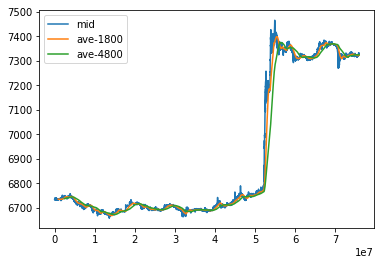

In [54]:
stats["ave-30"] = stats.loc[:, "mid"].rolling(30).mean() #15s
stats["ave-120"] = stats.loc[:, "mid"].rolling(120).mean() #1m
stats["ave-360"] = stats.loc[:, "mid"].rolling(360).mean() #3m
stats["ave-600"] = stats.loc[:, "mid"].rolling(600).mean() #5m
stats["ave-1200"] = stats.loc[:, "mid"].rolling(1200).mean() #5m
stats["ave-1800"] = stats.loc[:, "mid"].rolling(1800).mean() #15m
stats["ave-2400"] = stats.loc[:, "mid"].rolling(2400).mean() #20m
stats["ave-3600"] = stats.loc[:, "mid"].rolling(3600).mean() #30m
stats["ave-4800"] = stats.loc[:, "mid"].rolling(4800).mean() #40m
stats["ave-7200"] = stats.loc[:, "mid"].rolling(7200).mean() #60m
stats["ave-14400"] = stats.loc[:, "mid"].rolling(14400).mean() #120m
plt.plot(stats.loc[:, "time"], stats.loc[:, "mid"])
#plt.plot(stats.loc[:, "time"], stats.loc[:, "ave-30"])
#plt.plot(stats.loc[:, "time"], stats.loc[:, "ave-120"])
#plt.plot(stats.loc[:, "time"], stats.loc[:, "ave-360"])
#plt.plot(stats.loc[:, "time"], stats.loc[:, "ave-600"])
#plt.plot(stats.loc[:, "time"], stats.loc[:, "ave-1200"])
plt.plot(stats.loc[:, "time"], stats.loc[:, "ave-1800"])
#plt.plot(stats.loc[:, "time"], stats.loc[:, "ave-2400"])
#plt.plot(stats.loc[:, "time"], stats.loc[:, "ave-3600"])
plt.plot(stats.loc[:, "time"], stats.loc[:, "ave-4800"])
#plt.plot(stats.loc[:, "time"], stats.loc[:, "ave-7200"])
#plt.plot(stats.loc[:, "time"], stats.loc[:, "ave-14400"])
#plt.plot(stats.loc[:, "time"], stats.loc[:, "mid"].rolling(6).mean())
#plt.plot(stats.loc[:, "time"], stats.loc[:, "mid"].rolling(18).mean())
plt.legend()
print("Memory:", getMBUsage())

In [40]:
def calcPortfolio(longS, shortS, commission):
    stats["mv-diff"] = (stats.loc[:, "mid"].rolling(longS).mean() - stats.loc[:, "mid"].rolling(shortS).mean())
    stats["mv-diff-next"] = stats["mv-diff"].shift(-1)
    stats["mv-diff-buy"] = ((stats["mv-diff"] > 0) & (stats["mv-diff-next"] < 0))
    stats["mv-diff-sell"] = ((stats["mv-diff"] < 0) & (stats["mv-diff-next"] > 0))
    actions = stats[(stats["mv-diff-buy"] == True) | (stats["mv-diff-sell"] == True)]
    
    #simulate portfolio
    portUSD = 0
    portBTC = 1
    portValue = numpy.zeros(len(stats))
    npStats = stats.values
    for a in range(len(npStats)):
        if npStats[a][-2] == True: #buy
            portBTC += portUSD / npStats[a][3] * commission
            portUSD = 0
        if npStats[a][-1] == True: #sell
            portUSD += portBTC * npStats[a][3] * commission
            portBTC = 0

        portValue[a] = portUSD + portBTC * npStats[a][3]
    
    return portValue

Memory: 660.082688


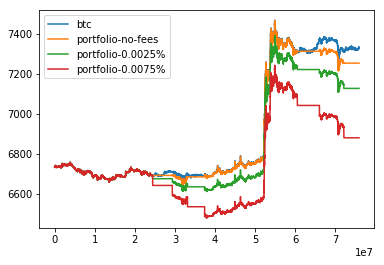

In [41]:
plt.plot(stats.loc[:, "time"], stats.loc[:, "mid"], label = "btc")
highTS = 14400
lowTS = 10136
plt.plot(stats.loc[:, "time"], calcPortfolio(highTS, lowTS, 1), label = "portfolio-no-fees")
plt.plot(stats.loc[:, "time"], calcPortfolio(highTS, lowTS, 0.9975), label = "portfolio-0.0025%")
plt.plot(stats.loc[:, "time"], calcPortfolio(highTS, lowTS, 0.9925), label = "portfolio-0.0075%")
plt.legend()
print("Memory:", getMBUsage())

In [42]:
def calcFinalPortValue(longPeriod, shortPeriod, commission, optimist):
    stats["mv-diff"] = (stats.loc[:, "mid"].rolling(longPeriod).mean() - stats.loc[:, "mid"].rolling(shortPeriod).mean())
    stats["mv-diff-next"] = stats["mv-diff"].shift(-1)
    stats["mv-diff-buy"] = ((stats["mv-diff"] > 0) & (stats["mv-diff-next"] < 0))
    stats["mv-diff-sell"] = ((stats["mv-diff"] < 0) & (stats["mv-diff-next"] > 0))
    actions = stats[(stats["mv-diff-buy"] == True) | (stats["mv-diff-sell"] == True)]
    
    #simulate portfolio
    portUSD = 0
    portBTC = 1
    npActions = actions.values
    for a in range(len(npActions)):
        if npActions[a][-2] == True: #buy
            if optimist:
                portBTC += portUSD / npActions[a][3] * commission
            else:
                portBTC += portUSD / npActions[a][2] * commission
            portUSD = 0
        if npActions[a][-1] == True: #sell
            if optimist:
                portUSD += portBTC * npActions[a][3] * commission
            else:
                portUSD += portBTC * npActions[a][1] * commission
            portBTC = 0
    
    return portUSD + portBTC * stats.values[-1][3]

print(calcFinalPortValue(14400, 10136, 0.9975, True))
print(calcPortfolio(14400, 10136, 0.9975)[-1])

7126.346405463601
7126.346405463601


Memory: 350.265344


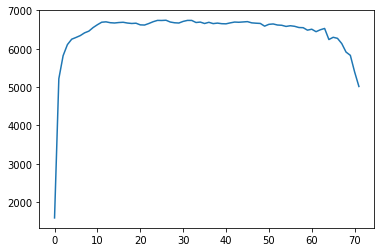

In [14]:
plt.plot([calcFinalPortValue(3600, a, 0.9975, True) for a in range(1, 3600, 50)])
print("Memory:", getMBUsage())

In [15]:
bestPV = 0
bestPVParams = None

PV_SEARCH_SPACE = 7200 * 12
PV_SEARCH_STEP = 200
portValues = numpy.zeros((PV_SEARCH_SPACE // PV_SEARCH_STEP, PV_SEARCH_SPACE // PV_SEARCH_STEP))
for a in range(14400, PV_SEARCH_SPACE, PV_SEARCH_STEP):
    print(bestPV, bestPVParams, (a - 14400) * 100 / (PV_SEARCH_SPACE - 14400), end = "\r")
    for b in range(PV_SEARCH_STEP, a, PV_SEARCH_STEP):
        portValues[a // PV_SEARCH_STEP][b // PV_SEARCH_STEP] = calcFinalPortValue(a, b, 0.9975, True)
        if portValues[a // PV_SEARCH_STEP][b // PV_SEARCH_STEP] > bestPV:
            bestPV = portValues[a // PV_SEARCH_STEP][b // PV_SEARCH_STEP]
            bestPVParams = (a, b)
            print(bestPV, bestPVParams, (a - 14400) * 100 / (PV_SEARCH_SPACE - 14400), end = "\r")

KeyboardInterrupt: 

Memory: 693.907456


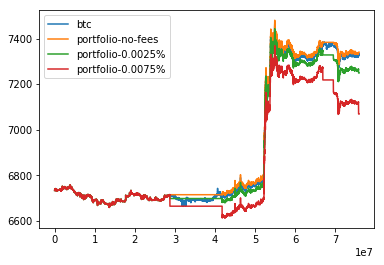

In [43]:
plt.plot(stats.loc[:, "time"], stats.loc[:, "mid"], label = "btc")
plt.plot(stats.loc[:, "time"], calcPortfolio(29000, 15400, 1), label = "portfolio-no-fees")
plt.plot(stats.loc[:, "time"], calcPortfolio(29000, 15400, 0.9975), label = "portfolio-0.0025%")
plt.plot(stats.loc[:, "time"], calcPortfolio(29000, 15400, 0.9925), label = "portfolio-0.0075%")
plt.legend()
print("Memory:", getMBUsage())

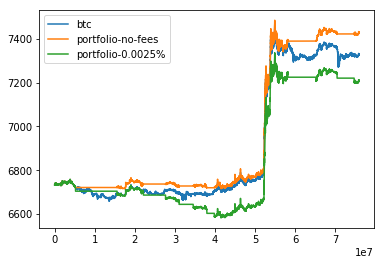

In [63]:
plt.plot(stats.loc[:, "time"], stats.loc[:, "mid"], label = "btc")
plt.plot(stats.loc[:, "time"], calcPortfolio(9600, 3600, 1), label = "portfolio-no-fees")
plt.plot(stats.loc[:, "time"], calcPortfolio(9600, 3600, 0.9975), label = "portfolio-0.0025%")
plt.legend()

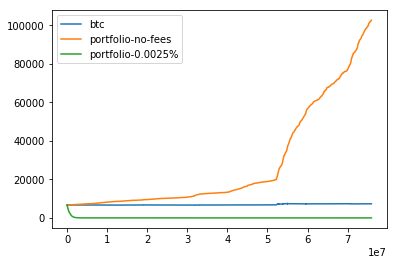

In [69]:
plt.plot(stats.loc[:, "time"], stats.loc[:, "mid"], label = "btc")
plt.plot(stats.loc[:, "time"], calcPortfolio(2, 1, 1), label = "portfolio-no-fees")
plt.plot(stats.loc[:, "time"], calcPortfolio(2, 1, 0.9975), label = "portfolio-0.0025%")
plt.legend()